<a id='Вернуться_к_оглавлению'></a>
# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.
---

## Описание данных
#### Технологический процесс
 * **Rougher feed** — исходное сырье
 * **Rougher additions (или reagent additions)** — флотационные реагенты: Xanthate, Sulphate, Depressant
 * **Xanthate** — ксантогенат (промотер, или активатор флотации);
 * **Sulphate** — сульфат (на данном производстве сульфид натрия);
 * **Depressant** — депрессант (силикат натрия).
 * **Rougher process (англ. «грубый процесс»)** — флотация
 * **Rougher tails** — отвальные хвосты
 * **Float banks** — флотационная установка
 * **Cleaner process** — очистка
 * **Rougher Au** — черновой концентрат золота
 * **Final Au** — финальный концентрат золота

#### Параметры этапов
 * **air amount** — объём воздуха
 * **fluid levels** — уровень жидкости
 * **feed size** — размер гранул сырья
 * **feed rate** — скорость подачи
 
#### Возможные значения для блока `этап`:
 * **rougher** — флотация
 * **primary_cleaner** — первичная очистка
 * **secondary_cleaner** — вторичная очистка
 * **final** — финальные характеристики

#### Возможные значения для блока `тип_параметра`:
 * **input** — параметры сырья
 * **output** — параметры продукта
 * **state** — параметры, характеризующие текущее состояние этапа
 * **calculation** — расчётные характеристики
---

### Разделим данное исследование на несколько частей

1. [Подготовка данных](#Подготовка_данных)
 * 1.1 Загрузка необзодимых библиотек.
 * 1.2 Расчет эфективности
 * 1.3 Различие обучающей и тестовой таблиц
 * 1.4 Заполнение пропусков 
 
2. [Анализ Данных](#Анализ_Данных)
 * 2.1 Анализ концентрации **(Au, Ag, Pb)** на различных этапах очистки.
 * 2.2 Сравните распределения размеров гранул сырья.
 * 2.3 Исследование суммарной концентрации веществ на разных стадиях очистки.
 * 2.4 Удаление аномалий.

3. [Построение модели](#Построение_модели)
 * 3.1 Создание функций для подсчета **sMAPE** и **итогового sMAPE**.
 * 3.2 Проверка моделей с помошью кросс валидации.
 * 3.3 Обучение модели.
 * 3.4 Получение **итогового sMAPE**.

---
<a id='Подготовка_данных'></a>
# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_df = pd.read_csv('/datasets/gold_recovery_train.csv')
test_df = pd.read_csv('/datasets/gold_recovery_test.csv')
full_df = pd.read_csv('/datasets/gold_recovery_full.csv')

pd.set_option('display.max_columns', None)

In [3]:
train_df.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

In [6]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

Проверим правильность вычисления обогащения, для этого создадим временную переменную `count` и высчитаем *MAE*.

In [7]:
count = train_df.copy()

In [8]:
count.dropna(subset = ['rougher.output.recovery'], inplace = True)

In [9]:
old = count['rougher.output.recovery']

In [10]:
def recovery(c, f, t):
    result = (c * (f - t) / (f*(c - t))) * 100
    return result

In [11]:
c = count['rougher.output.concentrate_au']
f = count['rougher.input.feed_au']
t = count['rougher.output.tail_au']

new = recovery(c,f,t)

In [12]:
mean_absolute_error(old, new)

9.444891926100695e-15

Среднее отклонение достаточно маленькое, что говорит о не больших различаях. Теперь изучим таблицы.

In [13]:
train_df.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [14]:
test_df.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

In [15]:
full_df.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

Проверим отличия в признаказ между `train_df` и `test_df`. Соберем их в отдельный список.

In [16]:
n_test = [i for i in train_df.columns if i not in test_df.columns] 
n_test

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

In [17]:
len(n_test)

34

Как видно из списка, в тестовой таблице отсутствуют 34 значения. Все эти значения показывают данные после прохождения определенного этапа обработки. Так же среди них есть целевые признаки **'rougher.output.recovery'** и  **'final.output.recovery'**.


Проверим пропущенные значения в таблицах.

In [18]:
train_df.isna().sum()

date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64

In [19]:
test_df.isna().sum()

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


In [20]:
full_df.isna().sum()

date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64

Убедимся, что пропуски не означают нулевые значения.

In [21]:
train_df.loc[train_df['rougher.output.recovery']==0]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
45,2016-01-16 21:00:00,4.566664,10.406178,4.588698,46.614456,68.403877,10.705777,1.509070,17.875134,2.509776,131.251366,13.969457,7.25,1.203034,8.513177,9.724797,19.120964,37.633572,16.455383,3.366501,6.864404,3.434734,1601.674776,-500.285160,1600.151967,-499.633542,1599.542959,-499.495721,1599.342687,-500.360306,41359.061159,3196.130244,3205.717062,2.530283,7.521974,2.811569,581.605260,65.620714,41.154430,7.114065,13.322740,7.504592,13.311361,7.493738,0.0,0.0,0.0,0.0,0.0,4.784398,0.818965,20.046797,1.939811,999.026619,-499.850895,1600.614880,-500.331775,1598.654561,-500.364377,1398.394100,-501.540155,1197.182011,-500.205806,1198.542180,-499.648335,13.605154,4.983564,9.545239,3.102137,25.963860,-498.097243,23.896954,-500.047419,24.963926,-500.207267,23.984937,-500.613261,14.025588,-550.404242,12.028925,-550.570104,10.052072,-500.797905,7.984500,-499.581046,11.982025,-599.161228
46,2016-01-16 22:00:00,4.577832,10.691605,5.274175,46.250638,70.675633,10.728531,1.641216,18.349339,2.540843,141.184039,13.978607,7.25,1.248254,8.466262,9.780929,19.220963,37.718947

Поменяем формат для даты, а так же запонима пропущенне значения в обучающей и тестовой выборках.

In [22]:
for i in (train_df, test_df, full_df):
    i['date'] = pd.to_datetime(i['date'], format='%Y-%m-%d %H:%M:%S')

In [23]:
for i in (train_df, full_df):
    i.dropna(subset = ['rougher.output.recovery'], inplace = True)

In [24]:
full_df['final.output.recovery'].isna().sum()

158

In [25]:
full_df.dropna(subset = ['rougher.output.recovery'], inplace = True)

In [26]:
for i in (train_df, test_df, full_df):
    i = i.ffill()

In [27]:
train_df = train_df.ffill()
test_df = test_df.ffill().reset_index(drop=True)
full_df = full_df.ffill().reset_index(drop=True)

In [28]:
for df in (train_df, test_df, full_df):
    if df.isna().sum().sum() != 0:
        print('Есть пропуски')
    else:
        print('Все пропуски заполнены')

Все пропуски заполнены
Все пропуски заполнены
Все пропуски заполнены


for df in (train_df, test_df, full_df):
    df = df.ffiill()

## Вывод
Были загружены данные, а так же необходимые библиотеки. Проверена правильность вычисления обогащения, найдены различия впризнаках между обучающей и тестовой выборках, заполнены пропущенные значения.

[Вернуться к оглавлению](#Вернуться_к_оглавлению)

<a id='Анализ_Данных'></a>
# 2. Анализ данных
Посмотрим на концентрацию *(Au, Ag, Pb)* на разных этапах очистки.

In [30]:
metall = ['au', 'ag', 'pb']

def processing_stages(process):         
    for item in metall:
        train_df[process+'_'+item].hist(bins=100, alpha=0.6, figsize=(12,6))
        plt.xlabel(process+'_'+item, fontsize=10)
        plt.ylabel('Количество', fontsize=10)
        plt.title('Концентрация металлов на этапе: '+process, fontsize=10)
        plt.legend(metall)

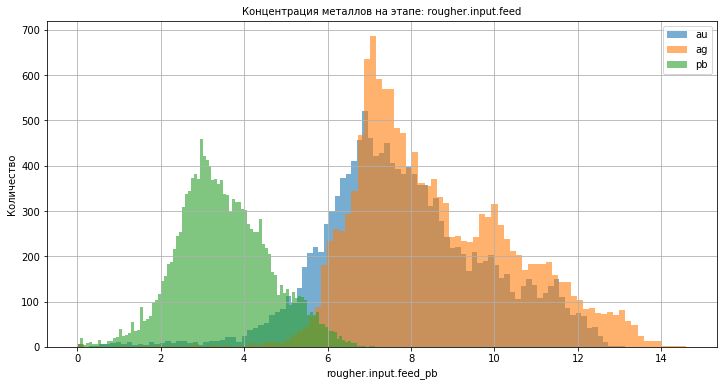

In [31]:
processing_stages('rougher.input.feed')

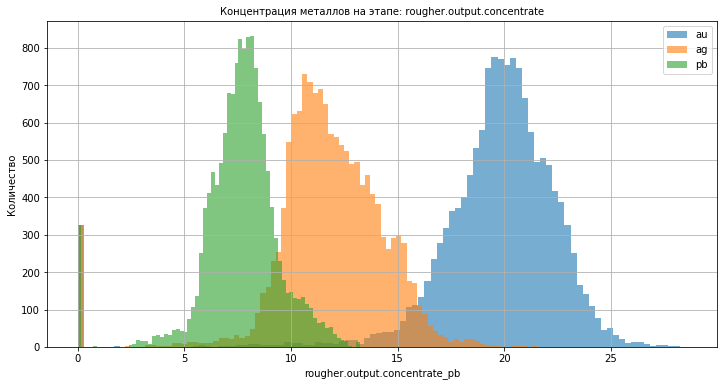

In [32]:
processing_stages('rougher.output.concentrate')

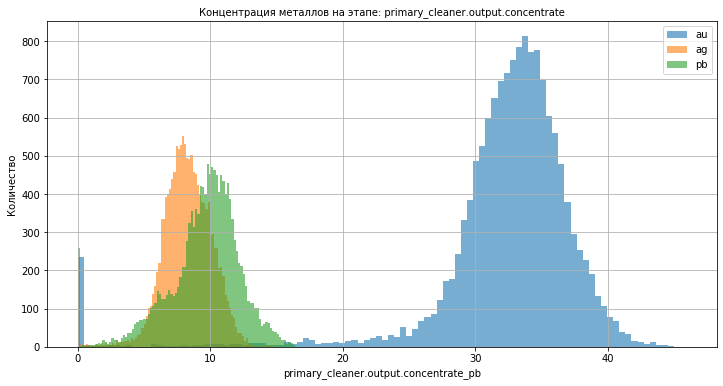

In [33]:
processing_stages('primary_cleaner.output.concentrate')

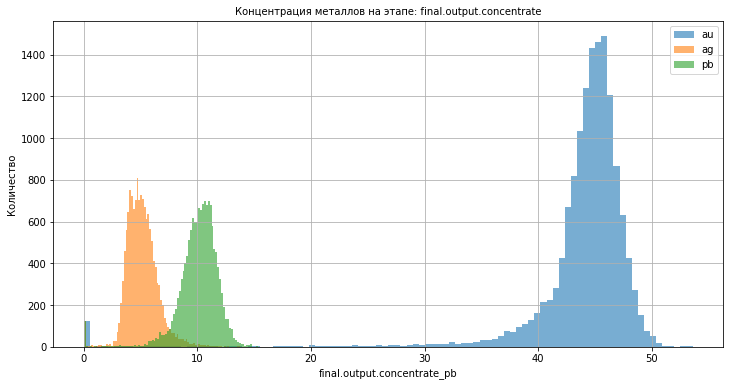

In [34]:
processing_stages('final.output.concentrate')

Из гистограмм видно, что конецентрация золота с каждым этапом растет, а концентрация свинца c серебром  остаются примерно на том же уровне, так же финальному этапу обработки серебро и свинец меняются местами. 

Теперь посмотрим на распределение размеров гранул сырья.

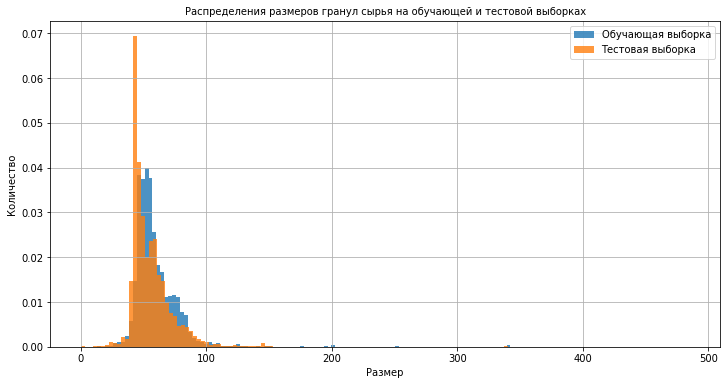

In [35]:
train_df['rougher.input.feed_size'].hist(bins=150, figsize=(12,6), alpha=0.8, density=True)
test_df['rougher.input.feed_size'].hist(bins=150, figsize=(12,6), alpha=0.8, density=True)
plt.xlabel('Размер', fontsize=10)
plt.ylabel('Количество', fontsize=10)
plt.title('Распределения размеров гранул сырья на обучающей и тестовой выборках', fontsize=10)
plt.legend(['Обучающая выборка', 'Тестовая выборка'])
plt.show()

Из гистограммы видно, что графики близки доруг к другу, что говорит, о схожих размерах гранул сырья.

Исследуем суммарную концентрацию всех веществ в сырье, в черновом и финальном концентратах.

In [36]:
names = ['rougher.input.feed', 'rougher.output.concentrate', 
                     'primary_cleaner.output.concentrate', 'final.output.concentrate']

def hists(symbol, df):         
    for process in names:
        df[process+'_'+symbol].hist(bins=100, alpha=0.6, figsize=(12,6))
        plt.xlabel(symbol, fontsize=10)
        plt.ylabel('Количество', fontsize=10)
        plt.title('Концентрация '+ symbol + ' на разных стадиях', fontsize=10)
        plt.legend(names)

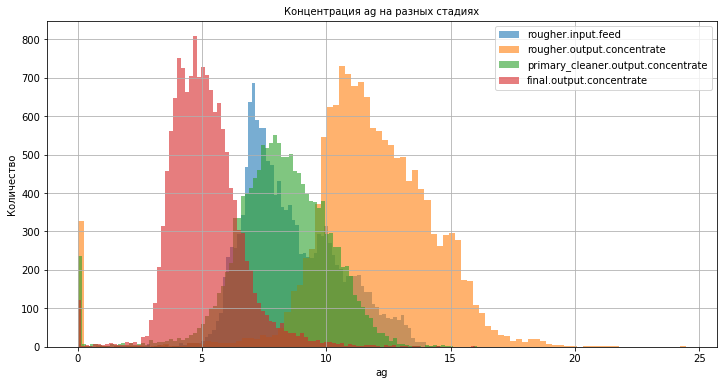

In [37]:
hists('ag', train_df)

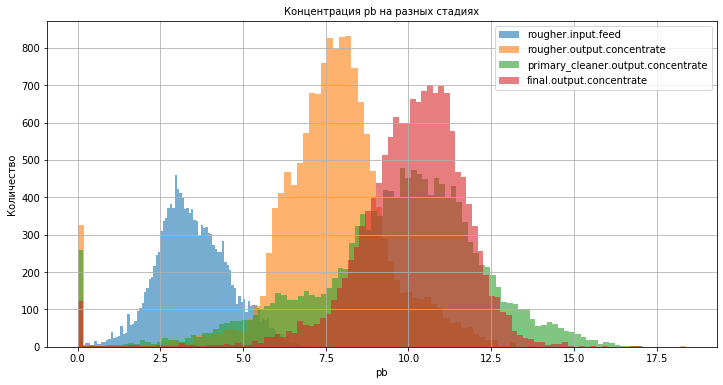

In [38]:
hists('pb', train_df)

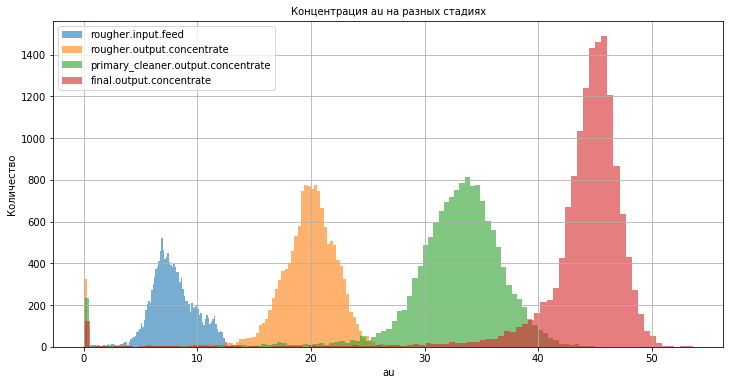

In [39]:
hists('au', train_df)

Как видно из гистограмм, у всех веществ аномальные значения около 0. Избавимся от них на тренировочной и тестовой выборках.

In [40]:
ind = train_df.loc[(train_df['rougher.input.feed_au']>=1) & (train_df['rougher.input.feed_ag']>=1)
             & (train_df['rougher.input.feed_sol']>=1) & (train_df['rougher.input.feed_ag']>=1) & 
                 (train_df['rougher.output.concentrate_au']>=1) & (train_df['rougher.output.concentrate_ag']>=1)
             & (train_df['rougher.output.concentrate_sol']>=1) & (train_df['rougher.output.concentrate_ag']>=1) & 
                 (train_df['primary_cleaner.output.concentrate_au']>=1) & (train_df['primary_cleaner.output.concentrate_ag']>=1)
             & (train_df['primary_cleaner.output.concentrate_sol']>=1) & (train_df['primary_cleaner.output.concentrate_ag']>=1) & 
                 (train_df['final.output.concentrate_au']>=1) & (train_df['final.output.concentrate_ag']>=1)
             & (train_df['final.output.concentrate_sol']>=1) & (train_df['final.output.concentrate_ag']>=1)]

In [41]:
test_ind = test_df.loc[(test_df['rougher.input.feed_au']>=1) & (test_df['rougher.input.feed_ag']>=1)
             & (test_df['rougher.input.feed_sol']>=1) & (test_df['rougher.input.feed_ag']>=1)]

Отфильтруем таблицы по индексам.

In [42]:
filtered_train_df = train_df[train_df.index.isin(ind.index)]

In [43]:
filtered_test_df = test_ind[test_ind.index.isin(test_ind.index)]

In [44]:
filtered_train_df.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

Проверим еще раз значения на гистограммах.

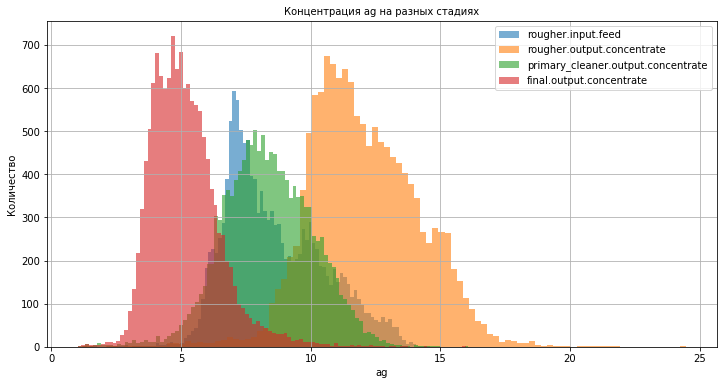

In [45]:
hists('ag',filtered_train_df)

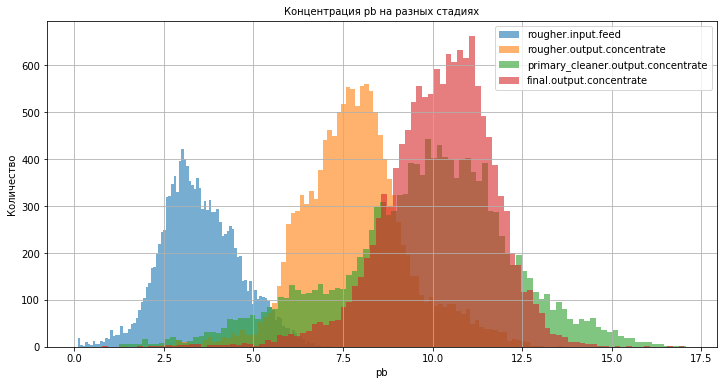

In [46]:
hists('pb',filtered_train_df)

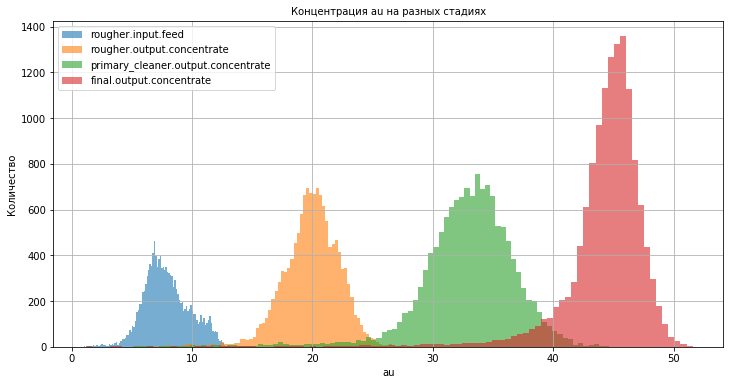

In [47]:
hists('au',filtered_train_df)

## Вывод
Была измерена концентрация веществ на разных этапах очистки. Так же проведено сравнение распределения размеров гранул сырья на обучающей и тестовой выборках. Были изучены аномалии и удалены.

[Вернуться к оглавлению](#Вернуться_к_оглавлению)

<a id='Построение_модели'></a>
# 3. Построение модели

Создадим функции для расчета **sMape** и **final_sMape**.

In [48]:
def smape(target, pred):
    return 1/len(target) * np.sum(2 * np.abs(target - pred) / (np.abs(target) + np.abs(pred))*100)

In [49]:
def smape_final(rougher, final):
    return 0.25 * rougher + 0.75 * final

In [50]:
scorer = make_scorer(smape, greater_is_better=True)

Разделим данные на таргеты и фичи, а так же масштабируем признаки.

In [51]:
features = filtered_test_df.columns.values
features_train = filtered_train_df[features[1:]].reset_index(drop=True)
features_test = filtered_test_df.drop('date', axis=1)

target_train_r = filtered_train_df['rougher.output.recovery']
target_train_f = filtered_train_df['final.output.recovery']

In [52]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

Проверим модели с помощью кросс валидации и найдем лучшую.

**DecisionTreeRegressor**

In [53]:
model_one = DecisionTreeRegressor(random_state=12345, max_depth=24)

In [54]:
cross_val_score(model_one, features_train, target_train_r, scoring=scorer, cv=5).mean()

10.598082059868627

In [55]:
cross_val_score(model_one, features_train, target_train_f, scoring=scorer, cv=5).mean()

15.145729279961586

**RandomForestRegressor**

In [56]:
model_two = RandomForestRegressor(random_state=12345, n_estimators=60, max_depth=25)

In [57]:
cross_val_score(model_two, features_train, target_train_r, scoring=scorer, cv=5).mean()

7.193509966124978

In [58]:
cross_val_score(model_two, features_train, target_train_f, scoring=scorer, cv=5).mean()

9.48791041815861

**LinearRegression**

In [59]:
model_three = LinearRegression()

In [60]:
cross_val_score(model_three, features_train, target_train_r, scoring=scorer, cv=5).mean()

7.328718478884786

In [61]:
cross_val_score(model_three, features_train, target_train_f, scoring=scorer, cv=5).mean()

10.862700678115205

In [62]:
model_three_normalized = LinearRegression(normalize=True)

In [63]:
cross_val_score(model_three_normalized, features_train, target_train_r, scoring=scorer, cv=5).mean()

7.328718478884783

In [64]:
cross_val_score(model_three_normalized, features_train, target_train_f, scoring=scorer, cv=5).mean()

10.862700678115202

**CatBoostRegressor**

In [65]:
cat_model = CatBoostRegressor(iterations=300, verbose=100,early_stopping_rounds=100, random_state=12345)

In [66]:
cross_val_score(cat_model, features_train, target_train_r, scoring=scorer, cv=5).mean()

0:	learn: 7.2337338	total: 59.5ms	remaining: 17.8s
100:	learn: 4.1398369	total: 7.33s	remaining: 14.4s
200:	learn: 3.5932314	total: 14.3s	remaining: 7.03s
299:	learn: 3.2688886	total: 20.6s	remaining: 0us
0:	learn: 7.8090901	total: 8.52ms	remaining: 2.55s
100:	learn: 4.4842047	total: 6.69s	remaining: 13.2s
200:	learn: 3.8985388	total: 13.4s	remaining: 6.62s
299:	learn: 3.5691641	total: 19.9s	remaining: 0us
0:	learn: 8.3414335	total: 34.6ms	remaining: 10.3s
100:	learn: 4.7221256	total: 8.25s	remaining: 16.3s
200:	learn: 4.1340313	total: 17.5s	remaining: 8.61s
299:	learn: 3.7621072	total: 24.6s	remaining: 0us
0:	learn: 8.0553138	total: 7.77ms	remaining: 2.32s
100:	learn: 4.7364107	total: 6.73s	remaining: 13.3s
200:	learn: 4.1163234	total: 14s	remaining: 6.88s
299:	learn: 3.7371114	total: 20.8s	remaining: 0us
0:	learn: 7.8268369	total: 7.45ms	remaining: 2.23s
100:	learn: 4.5706584	total: 6.67s	remaining: 13.1s
200:	learn: 3.9930863	total: 13.8s	remaining: 6.8s
299:	learn: 3.6249578	total:

6.176106546018516

In [67]:
cross_val_score(cat_model, features_train, target_train_f, scoring=scorer, cv=3).mean()

0:	learn: 9.0762096	total: 7.11ms	remaining: 2.13s
100:	learn: 6.4433944	total: 5.71s	remaining: 11.2s
200:	learn: 5.9157963	total: 12.3s	remaining: 6.08s
299:	learn: 5.5510670	total: 17.8s	remaining: 0us
0:	learn: 8.8699759	total: 7.08ms	remaining: 2.12s
100:	learn: 6.4183452	total: 5.77s	remaining: 11.4s
200:	learn: 5.9071410	total: 11.8s	remaining: 5.82s
299:	learn: 5.5417383	total: 17.4s	remaining: 0us
0:	learn: 8.6328285	total: 6.76ms	remaining: 2.02s
100:	learn: 6.1554442	total: 6.01s	remaining: 11.8s
200:	learn: 5.5914978	total: 11.5s	remaining: 5.65s
299:	learn: 5.2329769	total: 17.1s	remaining: 0us


10.479628904299773

Из всех моделей **CatBoostRegressor** показал наилучшие результаты. Используем эту модель для обучения. И проверим эту модель на тестовой выборке.

In [68]:
cat_model_r = CatBoostRegressor(iterations=300, verbose=100, early_stopping_rounds=100, random_state=12345)
cat_model_r.fit(features_train, target_train_r)
predicted_r = cat_model_r.predict(features_test)
predicted_r

0:	learn: 7.9116508	total: 8.21ms	remaining: 2.45s
100:	learn: 4.6372539	total: 6.89s	remaining: 13.6s
200:	learn: 4.0703285	total: 14s	remaining: 6.91s
299:	learn: 3.7219437	total: 20.5s	remaining: 0us


array([87.37985462, 87.30666565, 87.68680331, ..., 92.11825373,
       91.89927965, 91.88614623])

In [69]:
cat_model_f = CatBoostRegressor(iterations=300, verbose=100,early_stopping_rounds=100, random_state=12345)
cat_model_f.fit(features_train, target_train_f)
predicted_f = cat_model_f.predict(features_test)
predicted_f

0:	learn: 8.9539326	total: 8ms	remaining: 2.39s
100:	learn: 6.5772698	total: 7.28s	remaining: 14.3s
200:	learn: 6.0927847	total: 14.3s	remaining: 7.05s
299:	learn: 5.7702396	total: 21.1s	remaining: 0us


array([68.09043267, 67.5515862 , 67.90658953, ..., 70.64252946,
       71.4733351 , 72.54421586])

Возьмем из полног одатафрейма значения `'rougher.output.recovery'` и `'final.output.recovery'` для того, что бы узнать **sMAPE**

In [70]:
target_test_df_r = full_df[full_df.index.isin(filtered_test_df.index)]['rougher.output.recovery']
target_test_df_f = full_df[full_df.index.isin(filtered_test_df.index)]['final.output.recovery']

Подсчитаем общий **sMAPE**

In [71]:
r_smape = smape(target_test_df_r, predicted_r)
f_smape = smape(target_test_df_f, predicted_f)
print('Значение финольного sMAPE:', smape_final(r_smape, f_smape))

Значение финольного sMAPE: 12.846211125062412


## Вывод

Была созданы функции для подсчета **sMAPE** и **sMAPE_final**. В кросс валидацию был добавлен скор **sMAPE**. Данные были масштабированы с помощью **StandardScaler()** Были проверены 4 модели. наименьшее симметричное среднее абсолютное процентное отклонение показала модель **CatBoostRegressor**. Модель была проверена на тестовой выборке, был высчитан **sMAPE_final**, который составил 12.85, что является допустимым значением.

[Вернуться к оглавлению](#Вернуться_к_оглавлению)